In [ ]:
import numpy as np
from google.colab import drive
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


latent_dim = 127
original_height = 64
original_width = 64
height = 4
width = 4
channels = 3
filters=256

save_dir= '/content/drive/MyDrive/images/'
drive.mount('/content/drive/')

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Select airplane and automobile images
airplane = x_train[y_train.flatten() == 0]
automobile = x_train[y_train.flatten() == 1]

#Normalize 0-1
airplane = airplane/255.
automobile=automobile/255.

Mounted at /content/drive/
170508288/170498071 [==============================] - 2s 0us/step


#<b>CIFAR10 Labels</b>

<b>

airplane   = 0<br>
automobile = 1<br>
bird       = 2<br>
cat        = 3<br>
deer       = 4<br>
dog        = 5<br>
frog       = 6<br>
horse      = 7<br>
ship       = 8<br>
truck      = 9

</b>


## The generator


First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a 
candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like 
noise. A possible solution is to use dropout on both the discriminator and generator.

In [ ]:
import keras
from keras import layers
import numpy as np
import os

z_dim = 100
y_dim = 1

z = keras.Input(shape=(latent_dim,))
y = keras.Input(shape=(y_dim,))
generator_input = layers.Concatenate()([z,y])

# First, transform the input into a 4x4 256-channels feature map
x = layers.Dense(filters * 4 * 4)(generator_input)
x = layers.Reshape((4, 4, filters))(x)

# Then, add a convolution layer
x = layers.Conv2D(filters, 3, padding='same')(x)
x = layers.ReLU()(x)

#UpSampling to 8x8x256
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters,4,padding='same')(x)
x = layers.ReLU()(x)

#UpSampling to 16x16x256
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters,4,padding='same')(x)
x = layers.ReLU()(x)

#UpSampling to 32x32x256
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters,4,padding='same')(x)
x = layers.ReLU()(x)

#UpSampling to 64x64x256
x = layers.UpSampling2D()(x)
x = layers.Conv2D(filters,4,padding='same')(x)
x = layers.ReLU()(x)

# Produce a 64x64x3 feature map
x = layers.Conv2D(channels, 1, activation='sigmoid', padding='same')(x)
generator = keras.models.Model([z,y], x)

generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 4096)         528384      concatenate[0][0]            

## The discriminator


Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two 
classes, either "generated image" or "real image that comes from the training set".

In [ ]:
#Discriminator input 64x64x3
discriminator_input = layers.Input(shape=(64, 64, channels))
x = layers.Conv2D(filters, 3, padding='same')(discriminator_input)
x = layers.LeakyReLU()(x)

#Downsampling to 32x32x256
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(filters, 3, padding='same')(x)
x = layers.LeakyReLU()(x)

#Downsampling to 16x16x256
x=layers.AveragePooling2D()(x)
x = layers.Conv2D(filters, 3, padding='same')(x)
x = layers.LeakyReLU()(x)

#Downsampling to 8x8x256
x=layers.AveragePooling2D()(x)
x = layers.Conv2D(filters, 3, padding='same')(x)
x = layers.LeakyReLU()(x)

#Downsampling to 4x4x256
x=layers.AveragePooling2D()(x)
x = layers.Conv2D(filters, 3, padding='same')(x)
x = layers.LeakyReLU()(x)

#4096x1
x = layers.Flatten()(x)

#Concatenate x-vector to 1x1 y-vector -> 4097x1
x=layers.Concatenate()([x,y])

#256x1
x = layers.Dense(filters, activation='relu')(x)

# One dropout layer - important trick!
x = layers.Dropout(0.6)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model([discriminator_input,y], x)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(learning_rate=0.0005, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 256)  7168        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 256)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 32, 32, 256)  0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [ ]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

generator_input=generator([z,y])
gan_output = discriminator([generator_input,y])
gan = keras.models.Model([z,y],gan_output)

gan_optimizer = keras.optimizers.RMSprop(learning_rate=0.0004,clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64, 64, 3)    5314563     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            3416833     model[0][0]                

In [ ]:
from skimage.transform import rescale, resize
from numpy import asarray
import os
import tensorflow as tf
from keras.preprocessing import image
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

#Rescale 32x32 images to 64x64
airplane = scale_images(airplane, (64,64,3))
automobile=scale_images(automobile, (64,64,3))

## How to train your DCGAN

Now we can start training. To recapitulate, this is schematically what the training loop looks like:

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

Let's implement it:

In [ ]:
# Loading pretrained weights
#gan.load_weights(save_dir+'gan27.h5')

iterations =7000
batch_size = 120
batch_size2= 60

# Start training loop
start = 0

#Assemble labels discriminating real from fake images
labels_2_b2 = np.concatenate([np.ones((batch_size2, 1)),
                             np.zeros((batch_size2, 1))])

labels_2_b = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])

labels_4_b2 = np.concatenate([np.ones((batch_size2, 1)),
                             np.zeros((batch_size2, 1)),
                            np.ones((batch_size2, 1)),
                             np.zeros((batch_size2, 1))])

# Add random noise to the labels - important trick!
labels_2_b2_noise = labels_2_b2 + 0.05 * np.random.random(labels_2_b2.shape)
labels_2_b_noise = labels_2_b + 0.05 * np.random.random(labels_2_b.shape)
labels_4_b2_noise =labels_4_b2 + 0.05 * np.random.random(labels_4_b2.shape)

#Initialize error lists
d_test_error = []
gan_test_error = []

for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
 
    # Decode them to fake images
    generated_images = generator.predict([random_latent_vectors,labels_2_b2_noise])
    
    # Combine them with real images
    stop = start + batch_size2
    real_airplane = airplane[start: stop]
    real_automobile = automobile[start:stop]
    #Concatenate fake images to real images
    combined_images = np.concatenate([generated_images, real_airplane,real_automobile])
 
    # Train the discriminator
    d_loss = discriminator.train_on_batch([combined_images,labels_4_b2_noise], labels_2_b_noise)
    d_test = discriminator.test_on_batch([combined_images,labels_4_b2_noise], labels_2_b_noise)

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model, where the discriminator weights are frozen)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    a_loss = gan.train_on_batch([random_latent_vectors,labels_2_b2_noise], misleading_targets)
    g_test = gan.test_on_batch([random_latent_vectors,labels_2_b2_noise], misleading_targets)
    
    start += batch_size2
    if start > len(airplane) - batch_size2:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        #gan.save_weights(save_dir+'gan27.h5')

        #Save errors
        d_test_error.append(d_test)
        gan_test_error.append(g_test)
        # Print metrics
        print('discriminator test at step %s: %s' % (step, d_test))
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('GAN test at step %s: %s' % (step, g_test))
        print("")

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'a_generated_' + str(step) + '.png'))

discriminator test at step 0: 0.6771150231361389
discriminator loss at step 0: 0.6945947408676147
GAN test at step 0: 0.7076556086540222

discriminator test at step 100: 0.6664872765541077
discriminator loss at step 100: 0.7291339039802551
GAN test at step 100: 0.8730646967887878

discriminator test at step 200: 0.687586784362793
discriminator loss at step 200: 0.6957611441612244
GAN test at step 200: 0.745562732219696

discriminator test at step 300: 0.5487728118896484
discriminator loss at step 300: 0.6193408966064453
GAN test at step 300: 0.6231167912483215

discriminator test at step 400: 0.5707157850265503
discriminator loss at step 400: 0.6562536358833313
GAN test at step 400: 0.6063148975372314

discriminator test at step 500: 0.5544050335884094
discriminator loss at step 500: 0.6771596670150757
GAN test at step 500: 0.717328667640686

discriminator test at step 600: 0.6342570185661316
discriminator loss at step 600: 0.6774969696998596
GAN test at step 600: 0.698919415473938

di

#Ploting Errors

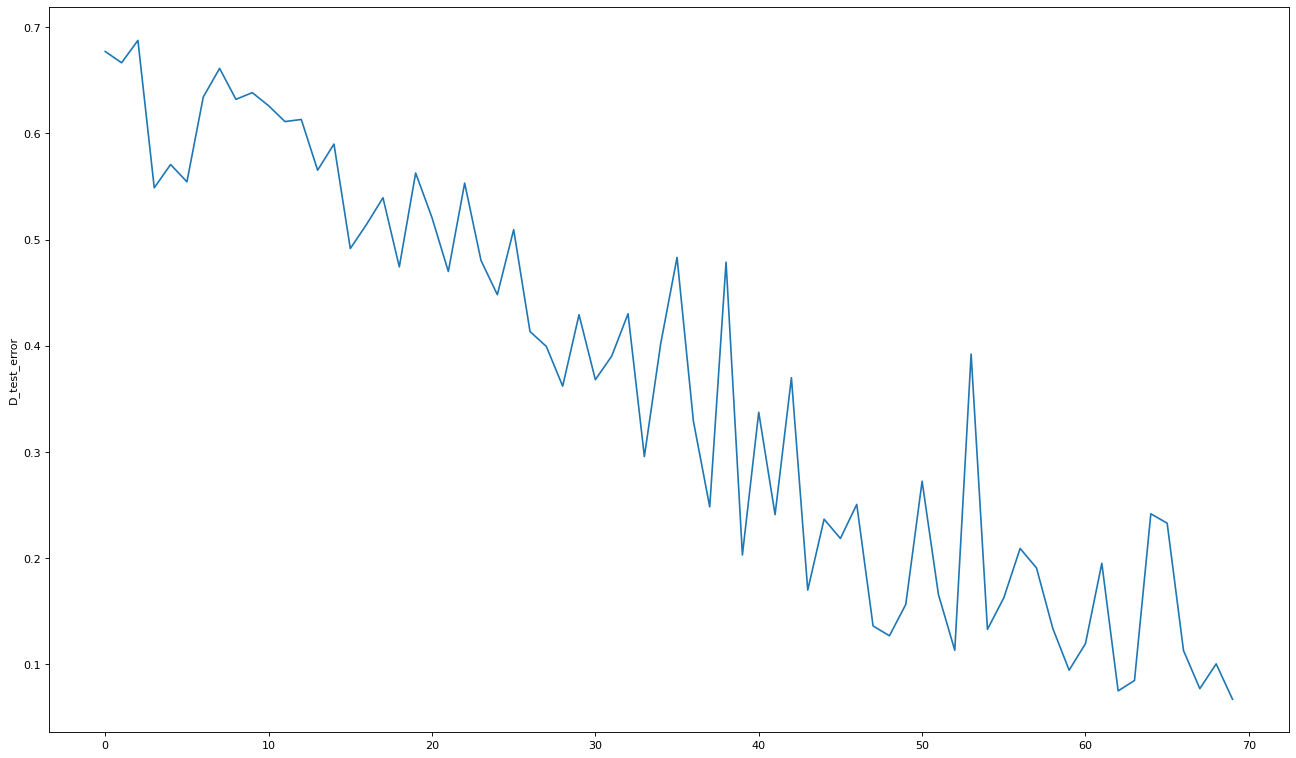

In [ ]:
figure(figsize=(20, 12), dpi=80)
plt.plot(d_test_error)
plt.ylabel('D_test_error')
plt.show()

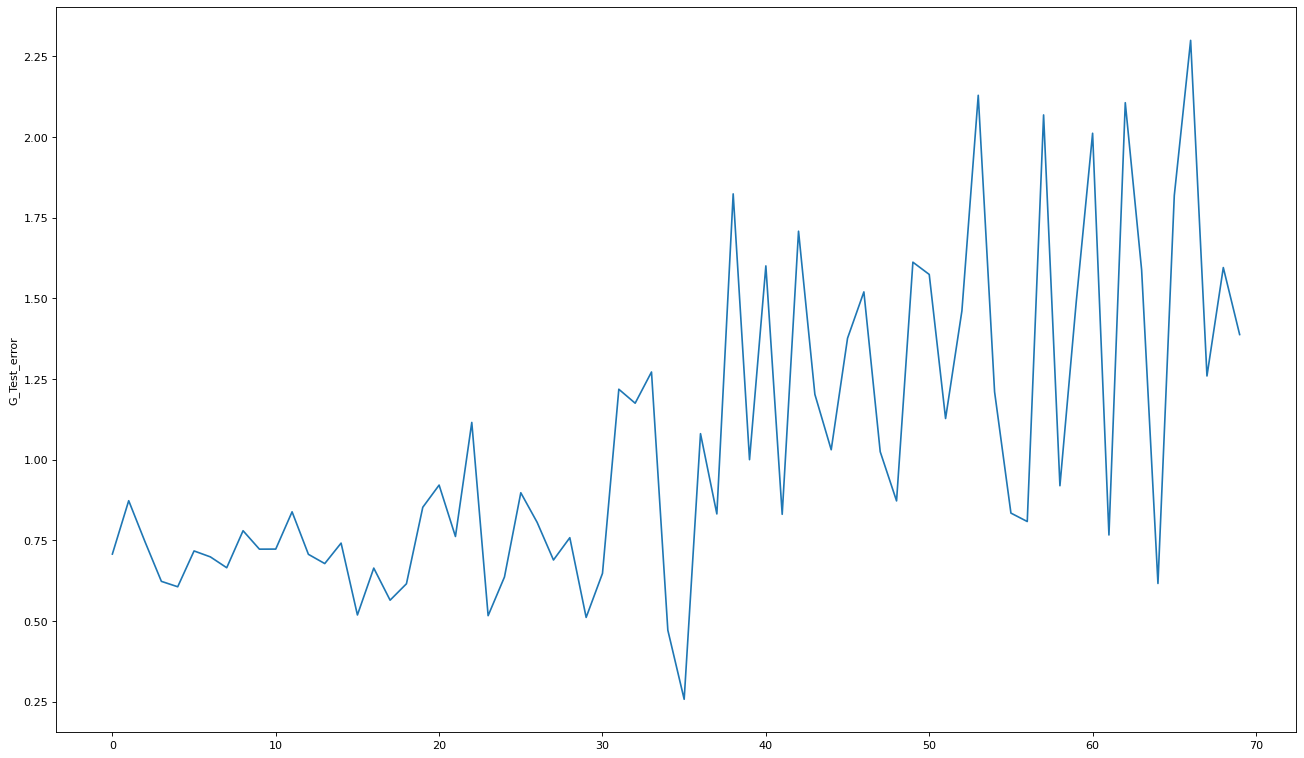

In [ ]:
figure(figsize=(20, 12), dpi=80)
plt.plot(gan_test_error)
plt.ylabel('G_Test_error')
plt.show()


#We generate 10 images of airplanes
### 1 = airplane <br>


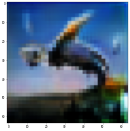

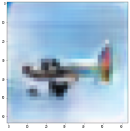

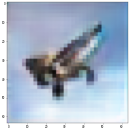

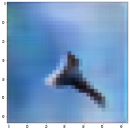

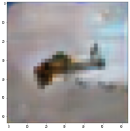

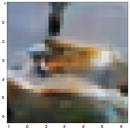

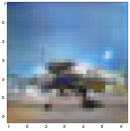

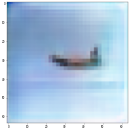

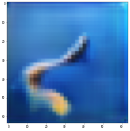

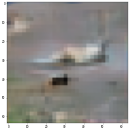

In [ ]:
labels3=np.concatenate([np.ones((10,1))])
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict([random_latent_vectors,labels3])

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    figure(figsize=(8, 8), dpi=20)
    plt.imshow(img)
    
plt.show()


#We generate 10 images of automobiles
### 0 = automobile <br>


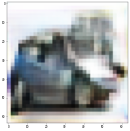

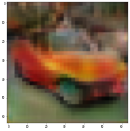

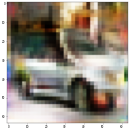

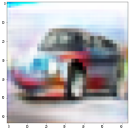

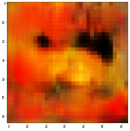

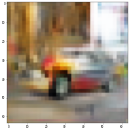

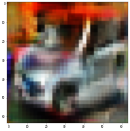

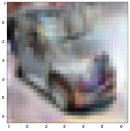

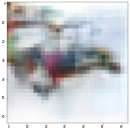

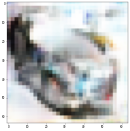

In [ ]:
labels3=np.concatenate([np.zeros((10,1))])
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict([random_latent_vectors,labels3])

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    figure(figsize=(8, 8), dpi=20)
    plt.imshow(img)
    
plt.show()